In [1]:
#EPieters HW5
#Question 1

In [2]:
import numpy as np
import matplotlib.pyplot as mpl
import glob
from simple_read_ligo import read_file, read_template
import json
from scipy.signal.windows import tukey

data_dir = 'LOSC_Event_tutorial/'

In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplo

In [3]:
#WINDOWING: use kaiser window
#add an extended flat region at the top of the kaiser window
#default is an eigth of the window
def flattop_kaiser(m, beta, flat=1/8, DEBUG=False):
    m_win = int(m*(1-flat))
    m_win += int(m_win%2) #want an even number
    
    win = np.kaiser(m_win, beta)
    pad = np.ones(m-m_win)
    win_full= np.insert(win, int(m_win/2), pad)
    
    if DEBUG:
        mpl.figure()
        mpl.plot(win)
        mpl.plot(win_full)
        mpl.show()
    
    return win_full


#plot the FT of the data with different methods:
#without window, with kaiser window, with flat kaiser window
#returns data with flat kaiser window and with kaiser window
def examine_window_methods(data, beta, flat=1/8, DEBUG=False):
    m = len(data)
    win_kaiser = np.kaiser(m, beta)
    win_flatkaiser = flattop_kaiser(m, beta, flat)
    
    data_kaiser = data*win_kaiser
    data_flatkaiser = data*win_flatkaiser
    
    fft_data = np.fft.rfft(data)
    fft_data_kaiser = np.fft.rfft(data_kaiser)
    fft_data_flatkaiser = np.fft.rfft(data_flatkaiser)

    mpl.figure()
    mpl.plot(win_kaiser)
    mpl.plot(win_flatkaiser)
    mpl.title('Windows')
    mpl.legend(['kaiser', 'kaiser with flat top'])
    mpl.show()
    
    mpl.figure()
    mpl.loglog(np.abs(fft_data))
    mpl.loglog(np.abs(fft_data_kaiser))
    mpl.loglog(np.abs(fft_data_flatkaiser))
    mpl.title('FFT of windowed data')
    mpl.legend(['No window', 'kaiser', 'kaiser with flat top'])
    mpl.show()
    
    if DEBUG:
            mpl.figure()
            mpl.loglog(np.abs(fft_data_kaiser))
            mpl.title('FFT of kaiser windowed data')
            mpl.show()
            
            mpl.figure()
            mpl.loglog(np.abs(fft_data_flatkaiser))
            mpl.title('FFT of flat kaiser windowed data')
            mpl.show()
    
    return fft_data_flatkaiser, fft_data_kaiser


#create boxcar smooth via convolution
#have option to take maximum
def boxcar_smooth(data, m, take_max=True, DEBUG=False):
    box = np.zeros(len(data))
    #make symmetrix boxcar
    box[:m] = 1
    box[-m:] = 1
    box = box/sum(box) #normalize
    print('sum of  box should now be 1 ', sum(box))

#     if DEBUG:
#         mpl.figure()
#         mpl.plot(box)
#         mpl.show()

    #convolve the boxcar with the data
    smooth_data = np.fft.ifft( np.fft.fft(data) * np.fft.fft(box) , len(data))

    if DEBUG:
        print('is total power convserved? these should be the same ')
        print(np.mean(data), np.mean(smooth_data))

    if take_max:
        max_smooth_data = np.maximum(data, smooth_data)

        print(np.mean(max_smooth_data))

        if DEBUG:
            mpl.figure()
            mpl.loglog(np.abs(data))
            mpl.loglog(np.abs(smooth_data))
#             mpl.loglog(np.abs(max_smooth_data))
            mpl.title('max data')
#             mpl.legend(['ogirinal', 'smoothed', 'max'])
            mpl.show()

        return max_smooth_data

    return smooth_data

#function returns template based on current file name
def get_template(fname):
    with open(data_dir + 'BBH_events_v3.json') as json_file: 
        template_dict = json.load(json_file)
    for ii in template_dict:
        if data_dir + template_dict[ii]['fn_H1'] == fname:
            tname = template_dict[ii]['name'] #the name of the template
            th, tl = read_template(data_dir + tname + '_4_template.hdf5') #read in template file
            return th 
        if data_dir + template_dict[ii]['fn_L1'] == fname:
            tname = template_dict[ii]['name'] #the name of the template
            th, tl = read_template(data_dir + tname + '_4_template.hdf5') #read in template file
            return tl
    print('ERROR: template not found for file ', fname)
    return 0


def search_data(template, data, Nft=1):
    return np.fft.irfft( np.conj(np.fft.rfft(template)) * (np.fft.rfft(data)/Nft), len(data))

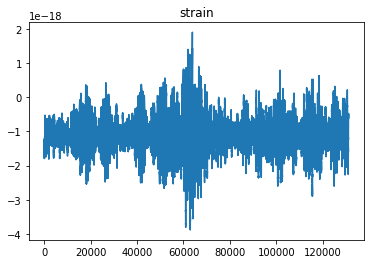

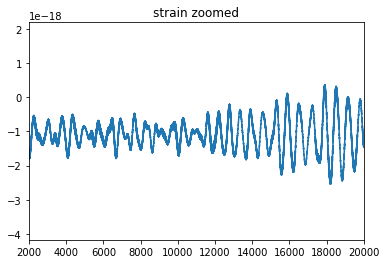

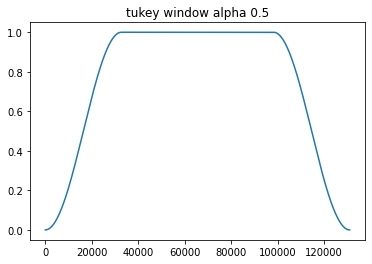

NameError: name 'fft_data_flatkaiser' is not defined

In [4]:
#PART A: come up with a noise model for Livingston and Hanford seperately

### READ IN DATA ###
livingston_files = glob.glob(data_dir + "L-*.hdf5")
hanford_files = glob.glob(data_dir + "H-*.hdf5")
# print(livingston_files)
# print(hanford_files)

fname = livingston_files[0]

#select a file
strain, dt, utc = read_file(fname)

#examine data
mpl.figure()
mpl.plot(strain)
mpl.title('strain')
mpl.show()

mpl.figure()
mpl.plot(strain)
mpl.title('strain zoomed')
mpl.xlim([2000, 20000])
mpl.show()


### WINDOWING AND SMOOTHING ###
#get different windowing methods

### OLD: KAISER WINDOW ###
#kaiser filter is used due to the adjustability, can be similar to hanning, hamming, blackman filter
# simply by adjusting beta
#also to extend flat period in middle to avoid diminishing important signals too much
#compares kaiser window with and without flat period. with flat period is chosen.
# beta = 5
# flat = 0.4
# fft_data_flatkaiser, fft_data_kaiser = examine_window_methods(strain, beta, flat, DEBUG=False)
# win = flattop_kaiser(len(strain), beta, flat) # will need this window later
# # win = np.kaiser(len(strain), beta)
# # win = np.ones(len(strain))

### NEW: TUKEY WINDOW ###
alpha = 0.5
win = tukey(len(strain), alpha)
fft_data_win = np.fft.rfft(win*strain)

mpl.figure()
mpl.plot(win)
mpl.title('tukey window alpha ' + repr(alpha))
mpl.show()


#smooth windowed data
boxcar_half_width = 5
fft_data_flatkaiser_smooth = boxcar_smooth(fft_data_flatkaiser, boxcar_half_width, take_max = False, DEBUG=False)
# fft_data_flatkaiser_smooth = boxcar_smooth(fft_data_kaiser, boxcar_half_width, take_max = False, DEBUG=False)


#examine effects on smoothing in frequency domain
mpl.figure()
mpl.loglog(np.abs(np.fft.fft(strain)))
mpl.loglog(np.abs(fft_data_flatkaiser))
mpl.loglog(np.abs(fft_data_flatkaiser_smooth))
mpl.title('FFT of data after windowing and smoothing')
mpl.legend(['original', 'windowed', 'windowed and smoothed'])
mpl.show()


#Produce noise matrix (noise in frequency space)
Nft = np.abs(fft_data_flatkaiser_smooth)**2

mpl.figure()
mpl.loglog(Nft)
mpl.title('Noise model in frequency space')
mpl.show()

In [ ]:
#PART B

#get the appropriate template for this data file
template = get_template(fname)

#window the template and the data
template_win = template*win
strain_win = strain*win

#perform a correlation taking into account the windowed, smoothed noise in fourier space
search = search_data(template_win, strain_win, Nft)

#perform a correlation taking into account the windowed, smoothed noise in fourier space
search_nowin = search_data(template, strain, Nft)

#what would the search have looked like with no noise estimate?
search_nonoise = search_data(template, strain)

mpl.figure()
mpl.plot(search)
mpl.show()

mpl.figure()
mpl.plot(search_nowin)
mpl.show()

mpl.figure()
mpl.plot(search_nonoise)
mpl.title('with no windowing and no noise')
mpl.show()

In [ ]:
#PART C: use other formula

#noise / standard deviation is the usual sqr(inv(AT N-1 A))
#signal to noise ratio is the m/sigma, the cross correlation divided by the error


#TODO: how to get SNR for COMBINED events?? multiply.....??


In [ ]:
#PART D:
#compare SNR from scatter in matched filter to analytic SNR from noise model. m/D vs eyeballing on graph?
#so basically matched filter correlation look 

In [ ]:
#PART E:
#look at power spectrum in prewhiteened space. N-1/2*A, then FT.